# Compute Capacity Analysis

This notebook analyzes compute capacities for various actors and visualizes the relationship between the available int8 operations and the number of stakeholders. It reads metadata from Markdown files, compiles them into a CSV, and then generates an SVG scatter plot with neatly arranged labels.

## Imports and Setup

This cell installs any missing third-party libraries and then imports everything needed for analysis. `os` and `csv` handle filesystem and CSV tasks. `math` supports logarithmic scaling. `PyYAML` reads front matter. `numpy` provides numerical arrays. `DBSCAN` clusters the points. `ConvexHull` outlines clusters. `matplotlib` draws the chart.

In [38]:
# Ensure required third-party packages are installed.
# Then import modules for file handling, mathematics, and plotting.
import importlib
import subprocess
import sys

def ensure_package(module_name, package_name):
    """Import module or install the package if needed."""
    try:
        importlib.import_module(module_name)
    except ModuleNotFoundError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package_name])

requirements = {
    'yaml': 'pyyaml',
    'numpy': 'numpy',
    'sklearn': 'scikit-learn',
    'scipy': 'scipy',
    'matplotlib': 'matplotlib',
}

for module, package in requirements.items():
    ensure_package(module, package)

import os
import csv
import math
from pathlib import Path
import yaml
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt


## Collect front matter and build `data.csv`

The Markdown files in the `entities` directory store metadata about each actor in a YAML front‑matter block. This code walks through every `.md` file in that directory, extracts the `name`, `compute` (renamed to `ops`), and `stakeholders` (renamed to `stakeholders`) fields, converts them to numeric types, and writes them out to a CSV file called `data.csv`. This CSV will be used for plotting in the next step.

In [39]:
# Define where to look for Markdown files containing compute metadata
try:
    base_dir = Path(__file__).parent
except NameError:
    base_dir = Path.cwd()

entities_dir = base_dir / 'entities'

if not entities_dir.exists():
    raise FileNotFoundError(f"{entities_dir} does not exist")
if not any(entities_dir.rglob('*.md')):
    raise FileNotFoundError(f"No Markdown files found in {entities_dir}")
# Prepare a list to hold the parsed rows
rows = []

for root, dirs, files in os.walk(entities_dir):
    for fname in files:
        if fname.endswith('.md'):
            path = os.path.join(root, fname)
            with open(path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
            # Extract front matter lines between the first two '---'
            in_front_matter = False
            front_lines = []
            for line in lines:
                if line.strip() == '---':
                    if not in_front_matter:
                        in_front_matter = True
                        continue
                    else:
                        # end of front matter
                        break
                if in_front_matter:
                    front_lines.append(line)
            # Parse front matter as YAML
            front_text = ''.join(front_lines)
            data = yaml.safe_load(front_text) or {}
            # Fetch required metadata fields from the front matter
            name = data.get('name')
            compute = data.get('compute')
            stakeholders = data.get('stakeholders')
            category = data.get('category')
            if name is None or compute is None or stakeholders is None or category is None:
                continue
            # Parse compute as float (scientific notation allowed)
            try:
                ops_value = float(compute)
            except ValueError:
                # Try to convert with replacements
                tmp = str(compute).lower().replace('×', 'e').replace('^', '')
                tmp = tmp.replace('int8', '')
                try:
                    ops_value = float(tmp)
                except Exception:
                    continue
            try:
                stakeholders_value = int(float(stakeholders))
            except ValueError:
                continue
            # Skip entries with zero compute
            if ops_value == 0:
                continue
            # Record the parsed values
            rows.append((name, category, ops_value, stakeholders_value))

# Write the collected data to a CSV file
csv_path = 'data.csv'
with open(csv_path, 'w', newline='', encoding='utf-8') as file_out:
    writer = csv.writer(file_out)
    writer.writerow(['name', 'category', 'ops', 'stakeholders'])
    for row in rows:
        writer.writerow(row)

# Print a preview of the rows collected
print(f"Collected {len(rows)} entries:")
for r in rows:
    print(r)


Collected 44 entries:
('Alphabet', 'corporation', 1e+20, 15)
('Amazon', 'corporation', 5e+19, 15)
('Apple', 'corporation', 5e+19, 12)
('California State University', 'academia', 5e+16, 200)
('Coral USB Accelerator', 'individuals', 4000000000000.0, 1)
('Elon Musk', 'oligarchs', 2e+20, 1)
('ETH Zürich', 'academia', 2e+17, 70)
('European Union', 'state actor', 2e+19, 100)
('Galaxy S24 Ultra', 'individuals', 45000000000000.0, 1)
('Government of India', 'state actor', 3e+17, 100)
('Government of Japan', 'state actor', 4e+18, 200)
('Indian Institute of Science', 'academia', 3e+16, 50)
('iPhone 16', 'individuals', 8600000000000.0, 1)
('NVIDIA Jetson Nano', 'individuals', 20000000000000.0, 1)
('Jetson Orin NX', 'individuals', 100000000000000.0, 1)
('Larry Ellison', 'oligarchs', 5e+19, 1)
('MacBook M3', 'individuals', 18000000000000.0, 1)
('Mark Zuckerberg', 'oligarchs', 5e+19, 1)
('Microsoft', 'corporation', 1e+20, 15)
('Moscow State University', 'academia', 2e+17, 70)
('National University of

This final step reads the data, colors each point by its category, and draws a key to explain the colors. Both axes use logarithmic scales: the horizontal axis for stakeholders counts and the vertical axis for estimated int8 operations per second. Most labels appear on the right side of the chart with connector lines. Labels for entries in the 'individuals' and 'oligarchs' categories sit on the left to keep the plot balanced.


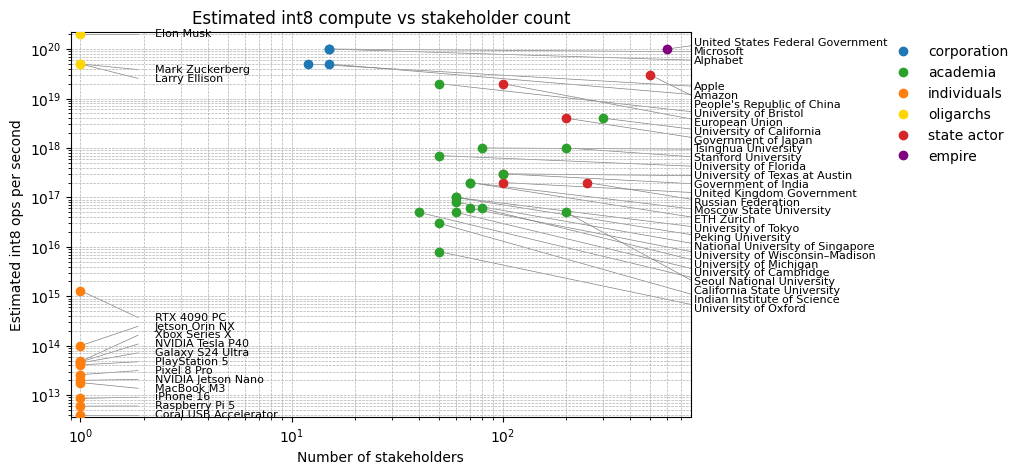

In [40]:
# Read the data from the CSV file
points = []
with open('data.csv', 'r', encoding='utf-8') as file_in:
    reader = csv.DictReader(file_in)
    for row in reader:
        name = row['name']
        ops = float(row['ops'])
        stakeholders = float(row['stakeholders'])
        category = row['category']
        point = {
            'name': name,
            'ops': ops,
            'stakeholders': stakeholders,
            'category': category,
        }
        points.append(point)

# Ensure there is data to plot
if not points:
    raise ValueError('No data points found in data.csv')

# Compute axis ranges
ops_values = [p['ops'] for p in points]
stakeholders_values = [p['stakeholders'] for p in points]
min_ops = min(ops_values)
max_ops = max(ops_values)
min_stakeholders = min(stakeholders_values)
max_stakeholders = max(stakeholders_values)

# Define figure dimensions in pixels and convert to inches for matplotlib
fig_width = 800
fig_height = 500
dpi = 100
fig, ax = plt.subplots(figsize=(fig_width / dpi, fig_height / dpi), dpi=dpi)

# Set up axes
ax.set_xlabel('Number of stakeholders')
ax.set_ylabel('Estimated int8 ops per second')
ax.set_xscale('log')
ax.set_yscale('log')
x_min = min_stakeholders * 0.9
x_max = max_stakeholders * 1.3
ax.set_xlim(x_min, x_max)
ax.set_ylim(min_ops * 0.9, max_ops * 1.1)
# Add a title summarizing the chart's purpose.
ax.set_title('Estimated int8 compute vs stakeholder count')

# Assign colors to each category based on sociocultural cues
category_colors = {
    'academia': 'tab:green',  # green represents growth and learning
    'corporation': 'tab:blue',  # blue is common in corporate branding
    'individuals': 'tab:orange',  # orange evokes independence
    'oligarchs': 'gold',  # gold reflects concentrated wealth
    'state actor': 'tab:red',  # red signals governmental authority
    'empire': 'purple',  # purple is traditionally imperial
}
fallback_colors = [
    'tab:brown',
    'tab:cyan',
    'tab:pink',
    'tab:gray',
]
series_colors = {}
fallback_index = 0
for point in points:
    category = point['category']
    if category not in series_colors:
        if category in category_colors:
            series_colors[category] = category_colors[category]
        else:
            color = fallback_colors[fallback_index % len(fallback_colors)]
            series_colors[category] = color
            fallback_index = fallback_index + 1

# Plot the points with category colors
for point in points:
    color = series_colors[point['category']]
    ax.scatter(point['stakeholders'], point['ops'], color=color, zorder=3)

# Sort points by log-scale y coordinate to determine label placement
sorted_points = sorted(points, key=lambda p: math.log10(p['ops']))

# Calculate label y positions evenly spaced along the plotting area
n = len(sorted_points)
if n > 1:
    y_min_log = math.log10(min_ops)
    y_max_log = math.log10(max_ops)
    spacing = (y_max_log - y_min_log) / (n - 1)
    y_positions = [10 ** (y_min_log + i * spacing) for i in range(n)]
else:
    y_positions = [min_ops]

# Place labels on both sides of the figure
left_categories = {'individuals', 'oligarchs'}
label_x_right = max_stakeholders * 1.35
anchor_right = label_x_right * 1.2
label_x_left = x_min / 0.4
anchor_left = label_x_left / 1.2
for point, label_y in zip(sorted_points, y_positions):
    if point['category'] in left_categories:
        x_text = label_x_left
        x_anchor = anchor_left
        align = 'left'
    else:
        x_text = label_x_right
        x_anchor = anchor_right
        align = 'left'
    ax.plot([point['stakeholders'], x_anchor], [point['ops'], label_y], color='gray', linewidth=0.5, zorder=1)
    ax.text(x_text, label_y, point['name'], va='center', ha=align, fontsize=8, zorder=2)

# Add grid for readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)

# Draw a legend showing category colors
legend_handles = []
for category, color in series_colors.items():
    handle = plt.Line2D([], [], marker='o', linestyle='', color=color, label=category)
    legend_handles.append(handle)
ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1.3, 1), frameon=False)

# Save the figure as an SVG file
svg_filename = 'chart.svg'
fig.savefig(svg_filename, format='svg', bbox_inches='tight')

# Display the SVG inline
from IPython.display import SVG, display as display_svg
with open(svg_filename, 'r', encoding='utf-8') as f:
    svg_content = f.read()
# display_svg(SVG(svg_content))


## DBSCAN Cluster Analysis

The final step groups points using DBSCAN on log-scaled coordinates. The first figure colors each cluster and saves it as `cluster_scatter.svg`. The second figure outlines each cluster's shape in the same color and saves it as `cluster_shapes.svg`.

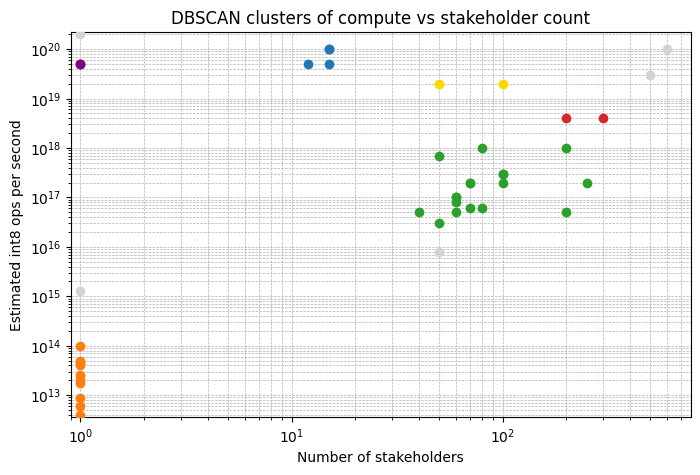

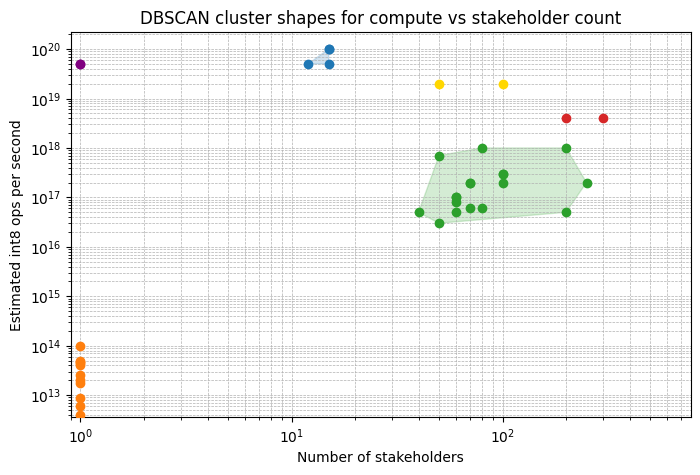

In [41]:
# Prepare log-transformed coordinates for clustering
coords = []
for point in points:
    x_value = math.log10(point['stakeholders'])
    y_value = math.log10(point['ops'])
    coords.append([x_value, y_value])
coords_array = np.array(coords)

# Run DBSCAN to identify clusters
dbscan = DBSCAN(eps=0.5, min_samples=2)
labels = dbscan.fit_predict(coords_array)

# Assign colors to clusters using the same palette
cluster_colors = {}
palette = list(series_colors.values())
palette_index = 0
for label in sorted(set(labels)):
    if label == -1:
        cluster_colors[label] = 'lightgray'
        continue
    color = palette[palette_index % len(palette)]
    cluster_colors[label] = color
    palette_index = palette_index + 1

# Plot each cluster in a separate color
cluster_fig, cluster_ax = plt.subplots(figsize=(fig_width / dpi, fig_height / dpi), dpi=dpi)
cluster_ax.set_xscale('log')
cluster_ax.set_yscale('log')
cluster_ax.set_xlabel('Number of stakeholders')
cluster_ax.set_ylabel('Estimated int8 ops per second')
cluster_ax.set_xlim(x_min, x_max)
cluster_ax.set_ylim(min_ops * 0.9, max_ops * 1.1)
# Title clarifies DBSCAN clustering context.
cluster_ax.set_title('DBSCAN clusters of compute vs stakeholder count')
cluster_ax.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)
for point, label in zip(points, labels):
    color = cluster_colors[label]
    cluster_ax.scatter(point['stakeholders'], point['ops'], color=color, zorder=3)
cluster_svg = 'cluster_scatter.svg'
cluster_fig.savefig(cluster_svg, format='svg', bbox_inches='tight')

# Draw convex hulls to show cluster shapes
shape_fig, shape_ax = plt.subplots(figsize=(fig_width / dpi, fig_height / dpi), dpi=dpi)
shape_ax.set_xscale('log')
shape_ax.set_yscale('log')
shape_ax.set_xlabel('Number of stakeholders')
shape_ax.set_ylabel('Estimated int8 ops per second')
shape_ax.set_xlim(x_min, x_max)
shape_ax.set_ylim(min_ops * 0.9, max_ops * 1.1)
# Title explains shaded DBSCAN cluster regions.
shape_ax.set_title('DBSCAN cluster shapes for compute vs stakeholder count')
shape_ax.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)
for label in sorted(set(labels)):
    if label == -1:
        continue
    color = cluster_colors[label]
    index_list = [i for i, l in enumerate(labels) if l == label]
    cluster_points = np.array([[coords_array[i][0], coords_array[i][1]] for i in index_list])
    if len(cluster_points) >= 3:
        try:
            hull = ConvexHull(cluster_points)
            hull_vertices = cluster_points[hull.vertices]
            shape_ax.fill(10 ** hull_vertices[:, 0], 10 ** hull_vertices[:, 1], alpha=0.2, color=color)
        except Exception:
            pass
    for i in index_list:
        point = points[i]
        shape_ax.scatter(point['stakeholders'], point['ops'], color=color, zorder=3)
shape_svg = 'cluster_shapes.svg'
shape_fig.savefig(shape_svg, format='svg', bbox_inches='tight')
